## Prediction Model

**Create a predictive analysis to determine the accuracy of the company's loan decisions**

**Starting off by checking loan_status once the loan was approved**

**find determining factors as to why the loan decision was rejected by lendingclub**

In [23]:
# First import librar dependacies : 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

In [2]:
# Run Boto3 to establish data connection to s3 bucket
import boto3
import awsKeyConfig
from io import StringIO

s3 = boto3.client('s3',
aws_access_key_id=awsKeyConfig.keyID,
aws_secret_access_key=awsKeyConfig.secretKey,
region_name='us-east-1'
)

In [3]:
# Retrieves the Bucket Name and Key <file_name> and 
obj = s3.get_object(Bucket='davis-data-cloud-of-wonders', Key='clean_loan_data.csv')
data = obj['Body'].read().decode('utf-8')

# Validates whether the connection to s3 is successfull or fail 
status = obj.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 put_object response. Status - {status}")
else:
    print(f"Unsuccessful S3 put_object response. Status - {status}")


# Use StringIO to convert the string data to a file-like object
data_file = StringIO(data)

# Create a DataFrame from the CSV data
loan_df = pd.read_csv(data_file)

loan_df.head()

Successful S3 put_object response. Status - 200


,loan_amnt,term,int_rate,application_type,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,annual_inc_joint,verification_status,loan_status,delinq_2yrs,purpose,addr_state,dti,fico_score,issued_year,default_loan
0,3600.0,36 months,13.99,Individual,123.03,C,C4,leadman,10+ years,MORTGAGE,...,NaN,Not Verified,Fully Paid,0.0,debt_consolidation,PA,5.91,677.0,2015.0,0
1,24700.0,36 months,11.99,Individual,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,NaN,Not Verified,Fully Paid,1.0,small_business,SD,16.06,717.0,2015.0,0
2,20000.0,60 months,10.78,Joint App,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,71000.0,Not Verified,Fully Paid,0.0,home_improvement,IL,10.78,697.0,2015.0,0
3,35000.0,60 months,14.85,Individual,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,...,NaN,Source Verified,Current,0.0,debt_consolidation,NJ,17.06,787.0,2015.0,0
4,10400.0,60 months,22.45,Individual,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,NaN,Source Verified,Fully Paid,1.0,major_purchase,PA,25.37,697.0,2015.0,0


In [4]:
# quick look at loan_status data types
loan_df['loan_status'].value_counts()

loan_status
Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
Late (16-30 days)        4349
Default                    40
Name: count, dtype: int64

In [12]:
# create an comparison between good and bad loan by clustering loan_status

bad_loan = ['Default', 'Charged Off', 'Late (31-120 days)']

loan_df['loan_condition'] = np.nan # omits the non-value

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
loan_df['loan_condition'] = loan_df['loan_status'].apply(loan_condition)

**A look at loan status visualization overview**

/Users/ddavis85/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ddavis85/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ddavis85/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ddavis85/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

[Text(0, 0.5, '(%)')]

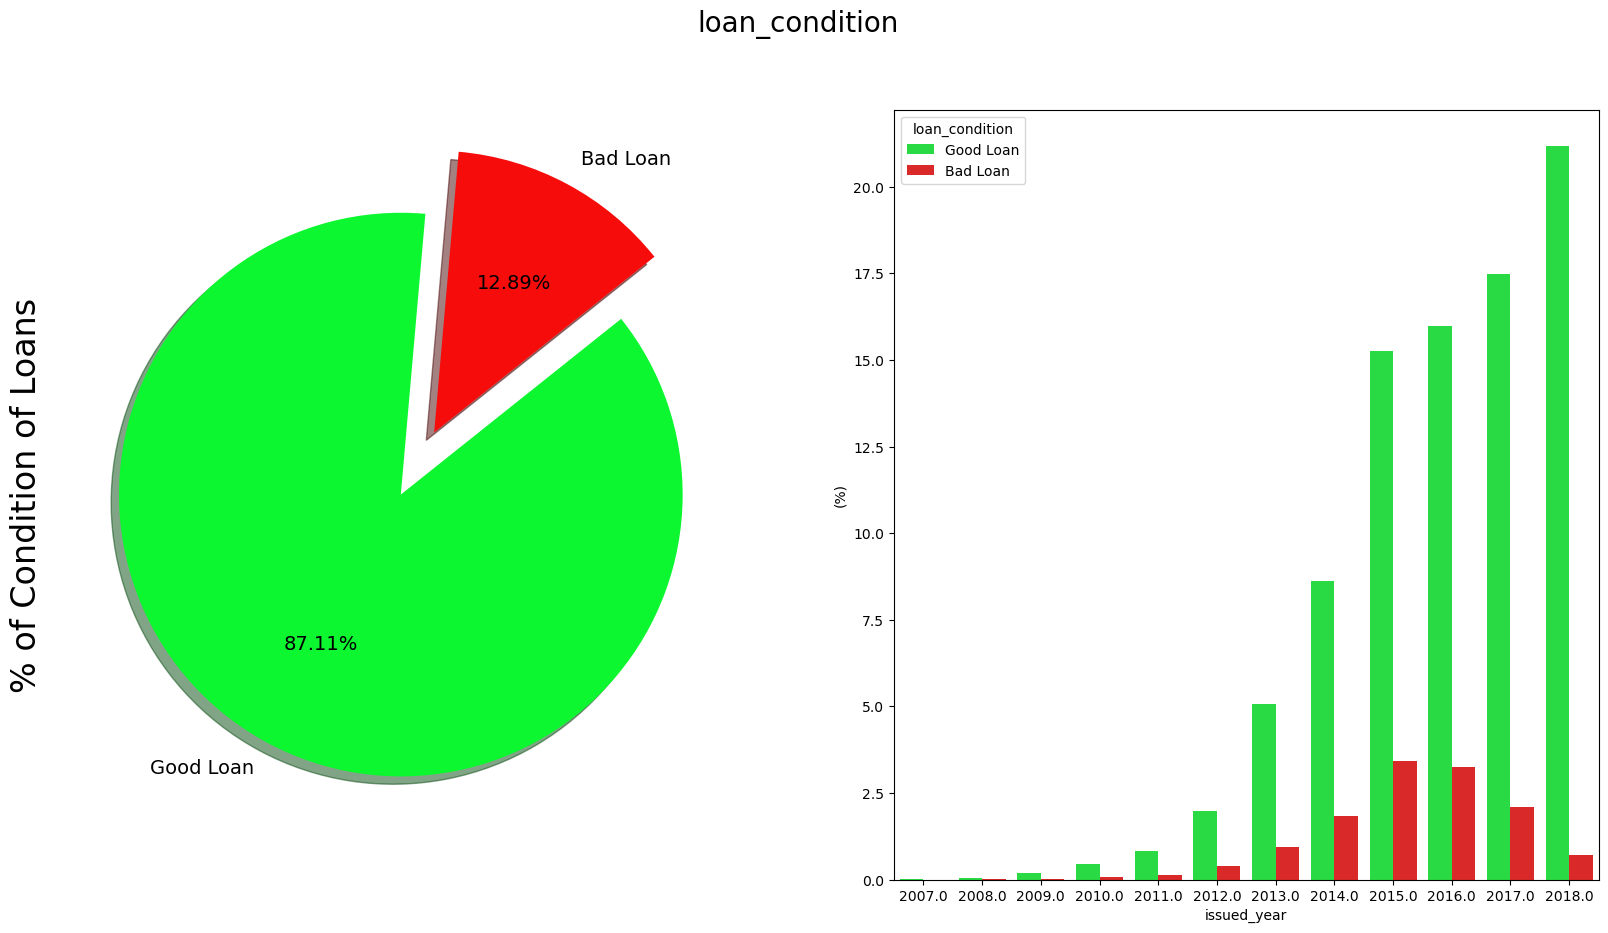

In [13]:
# Create Pie Chart to review the loan_status

f, ax = plt.subplots(1,2, figsize=(20,10))

colors = ["#0cf730", "#f70c0c"]
labels =  "Good Loan", "Bad Loan"
explode = [0, 0.25]


plt.suptitle('loan_condition', fontsize=20)

loan_df['loan_condition'].value_counts().plot.pie(explode = explode, autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=14, startangle=85)

ax[0].set_ylabel('% of Condition of Loans', fontsize=24)

sns.barplot(x="issued_year", y="loan_amnt", hue="loan_condition", data=loan_df, palette=colors, estimator=lambda x: len(x) / len(loan_df) * 100)
ax[1].set(ylabel="(%)")

**Taking a Deeper look at the Bad Loan**

going to review the bad loan data by region

In [7]:
# review the regions dataset by unique value
loan_df['addr_state'].unique()

array(['PA', 'SD', 'IL', 'NJ', 'GA', 'MN', 'SC', 'RI', 'TX', 'NC', 'CA',
       'VA', 'AZ', 'NY', 'IN', 'MD', 'KS', 'NM', 'AL', 'WA', 'MO', 'OH',
       'LA', 'FL', 'CO', 'MI', 'TN', 'DC', 'MA', 'WI', 'HI', 'VT', 'DE',
       'NH', 'NE', 'CT', 'OR', 'AR', 'MT', 'NV', 'WV', 'WY', 'OK', 'KY',
       'MS', 'ME', 'UT', 'ND', 'AK', nan, 'ID', 'IA'], dtype=object)

In [8]:
# going to take data by regions : North_East, South_East, Mid_West, South_West, West
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

loan_df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'South West'
    elif state in south_east:
        return 'South East'
    elif state in mid_west:
        return 'Mid West'
    elif state in north_east:
        return 'North East'
    


loan_df['region'] = loan_df['addr_state'].apply(finding_regions)

In [9]:
loan_df.head()

,loan_amnt,term,int_rate,application_type,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,loan_status,delinq_2yrs,purpose,addr_state,dti,fico_score,issued_year,default_loan,loan_condition,region
0,3600.0,36 months,13.99,Individual,123.03,C,C4,leadman,10+ years,MORTGAGE,...,Fully Paid,0.0,debt_consolidation,PA,5.91,677.0,2015.0,0,Good Loan,North East
1,24700.0,36 months,11.99,Individual,820.28,C,C1,Engineer,10+ years,MORTGAGE,...,Fully Paid,1.0,small_business,SD,16.06,717.0,2015.0,0,Good Loan,Mid West
2,20000.0,60 months,10.78,Joint App,432.66,B,B4,truck driver,10+ years,MORTGAGE,...,Fully Paid,0.0,home_improvement,IL,10.78,697.0,2015.0,0,Good Loan,Mid West
3,35000.0,60 months,14.85,Individual,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,...,Current,0.0,debt_consolidation,NJ,17.06,787.0,2015.0,0,Good Loan,North East
4,10400.0,60 months,22.45,Individual,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,...,Fully Paid,1.0,major_purchase,PA,25.37,697.0,2015.0,0,Good Loan,North East


In [10]:
# creating dataframe called bad loan and retriving count of bad loans
bad_loan_df = loan_df.loc[loan_df['loan_condition'] == 'Bad Loan']
bad_loan_df['loan_condition'].value_counts()

loan_condition
Bad Loan    294415
Name: count, dtype: int64

In [14]:
# going to use an pandas function called crosstab 
# Crosstab builds a cross-tabulation table that can show the frequency with which certain groups of data appear.

loan_cross_tab = pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']).apply(lambda x: x/x.sum() * 100)
num_loan_status = pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status'])

# using lambda to round the values
loan_cross_tab['Charged Off'] = loan_cross_tab['Charged Off'].apply(lambda x: round(x, 2))
loan_cross_tab['Default'] = loan_cross_tab['Default'].apply(lambda x: round(x, 2))
loan_cross_tab['Late (31-120 days)'] = loan_cross_tab['Late (31-120 days)'].apply(lambda x: round(x, 2))

# adding all the values in an Total column
num_loan_status['Total'] = num_loan_status.sum(axis=1)

num_loan_status

loan_status,Charged Off,Default,Late (16-30 days),Late (31-120 days),Total
region,,,,,
Mid West,46377,7,649,3476,50509
North East,62535,13,1110,5181,68839
South East,67229,7,1138,5549,73923
South West,32712,6,515,2671,35904
West,59706,7,937,4590,65240


In [28]:
# adding each loan status values to a list 
charged = loan_cross_tab['Charged Off'].values.tolist()
default = loan_cross_tab['Default'].values.tolist()
late = loan_cross_tab['Late (31-120 days)'].values.tolist()

In [30]:
# Creating bar plots using library called go from Plotly

charged_plot = go.Bar(
    x = ['Mid West', 'North East', 'South East', 'South West', 'West'],
    y = charged,
    name = 'Charged Off',
    marker = dict(color = 'rgb(176, 26, 26)'), text = "%"
    )

default_plot = go.Bar(
    x = ['Mid West', 'North East', 'South East', 'South West', 'West'],
    y = default,
    name = 'Default',
    marker = dict(color = 'rgb(229, 121, 36)'), text = "%"
    )

late_plot = go.Bar(
    x = ['Mid West', 'North East', 'South East', 'South West', 'West'],
    y = late,
    name = 'Late Payment (31-120 days)',
    marker = dict(color = 'rgb(246, 157, 135)'), text = "%"
    )

data = [charged_plot, default_plot, late_plot]
layout = go.Layout(
                        barmode= 'stack', 
                        title= "% of Bad Loan Status by Region", 
                        xaxis = dict(title = "US Regions")
                        )

fig = go.Figure(data = data, layout = layout)

